In [11]:
from pyspark.sql import SparkSession
from pyspark.sql import functions as F

spark = SparkSession.builder \
    .appName("CBRFSS") \
    .config("spark.executor.memory", "4g") \
    .config("spark.driver.memory", "4g") \
    .config("spark.executor.cores", "4") \
    .config("spark.executor.instances", "4") \
    .getOrCreate()


In [12]:
file_path = "output/processedv3.parquet"

df = spark.read.parquet(file_path)

df_filled = df.na.drop()
train_df, test_df = df_filled.randomSplit([0.8, 0.2], seed=1)
# Show the counts of each split
print(f"Training set count: {train_df.count()}")
print(f"Test set count: {test_df.count()}")

Training set count: 76274
Test set count: 19300


In [13]:
from pyspark.ml.feature import VectorAssembler, OneHotEncoder
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.sql import functions as F
from pyspark.ml.evaluation import MulticlassClassificationEvaluator


# Categorical features
categorical_features = ["EMPLOY1", "ALCDAY4", "FALL12MN"]

# One-Hot Encoding
encoder = OneHotEncoder(
    inputCols=categorical_features,
    outputCols=[feature + "_ohe" for feature in categorical_features],
)

# Fit and transform the encoder on the training data
encoder_model = encoder.fit(train_df)
train_df = encoder_model.transform(train_df)
test_df = encoder_model.transform(test_df)

# Remove original categorical features
train_df = train_df.drop(*categorical_features)
test_df = test_df.drop(*categorical_features)

# Prepare feature columns (include one-hot encoded columns)
feature_columns = [col for col in train_df.columns if col != "y"]

# Assemble features into a single vector
assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")
train_data = assembler.transform(train_df)
test_data = assembler.transform(test_df)

In [14]:
# Decision tree

decision_tree = DecisionTreeClassifier(featuresCol="features", labelCol="y")

# Set up hyperparameter tuning
paramGrid = (
    ParamGridBuilder()
    .addGrid(decision_tree.maxDepth, [5, 6, 7])
    .addGrid(decision_tree.minInstancesPerNode, [1, 2, 3])
    .build()
)

# Set up cross-validation
evaluator = MulticlassClassificationEvaluator(
    labelCol="y", predictionCol="prediction", metricName="accuracy"
)
crossval = CrossValidator(
    estimator=decision_tree,
    estimatorParamMaps=paramGrid,
    evaluator=evaluator,
    numFolds=5,
)

# Train the model using Cross-Validation
cv_model = crossval.fit(train_data)

# Evaluate on the test set
test_predictions = cv_model.transform(test_data)

# Evaluate model accuracy on the test data
test_accuracy = evaluator.evaluate(test_predictions)
print(f"Test Accuracy: {test_accuracy:.4f}")

# Extract and display the best decision tree model structure
print(cv_model.bestModel.toDebugString)

# Group predictions by the predicted class
test_predictions.groupBy("prediction").count().show()

Test Accuracy: 0.8501
DecisionTreeClassificationModel: uid=DecisionTreeClassifier_860f6a4f214a, depth=5, numNodes=11, numClasses=2, numFeatures=1000
  If (feature 0 <= 2.5)
   Predict: 0.0
  Else (feature 0 > 2.5)
   If (feature 2 <= 1.5)
    Predict: 0.0
   Else (feature 2 > 1.5)
    If (feature 0 <= 3.5)
     Predict: 0.0
    Else (feature 0 > 3.5)
     If (feature 6 <= 1.5)
      Predict: 0.0
     Else (feature 6 > 1.5)
      If (feature 8 <= 3.5)
       Predict: 0.0
      Else (feature 8 > 3.5)
       Predict: 1.0

+----------+-----+
|prediction|count|
+----------+-----+
|       0.0|18373|
|       1.0|  927|
+----------+-----+



In [15]:
# Evaluate the model's weighted precision
evaluator = MulticlassClassificationEvaluator(labelCol="y", predictionCol="prediction", metricName="weightedPrecision")
weighted_precision = evaluator.evaluate(test_predictions)

print(f"Weighted Precision: {weighted_precision:.4f}")

Weighted Precision: 0.8159


In [16]:
# Feature Importance
importances = cv_model.bestModel.featureImportances
feature_importance = [(name, importance) for name, importance in zip(feature_columns, importances)]
sorted_features = sorted(feature_importance, key=lambda x: x[1], reverse=True)
print("Feature Importances:")
for feature, importance in sorted_features:
    print(f"{feature}: {importance:.4f}")

Feature Importances:
GENHLTH: 0.6300
_RFHYPE6: 0.2890
_RFCHOL3: 0.0502
_BMI5CAT: 0.0308
_AGEG5YR: 0.0000
_MICHD: 0.0000
_DRDXAR2: 0.0000
_HCVU653: 0.0000
METVL12_: 0.0000
DIFFWALK: 0.0000
_TOTINDA: 0.0000
EDUCA: 0.0000
_INCOMG1: 0.0000
CHCKDNY2: 0.0000
SMOKE100: 0.0000
CVDINFR4: 0.0000
EMPLOY1_ohe: 0.0000
ALCDAY4_ohe: 0.0000
FALL12MN_ohe: 0.0000


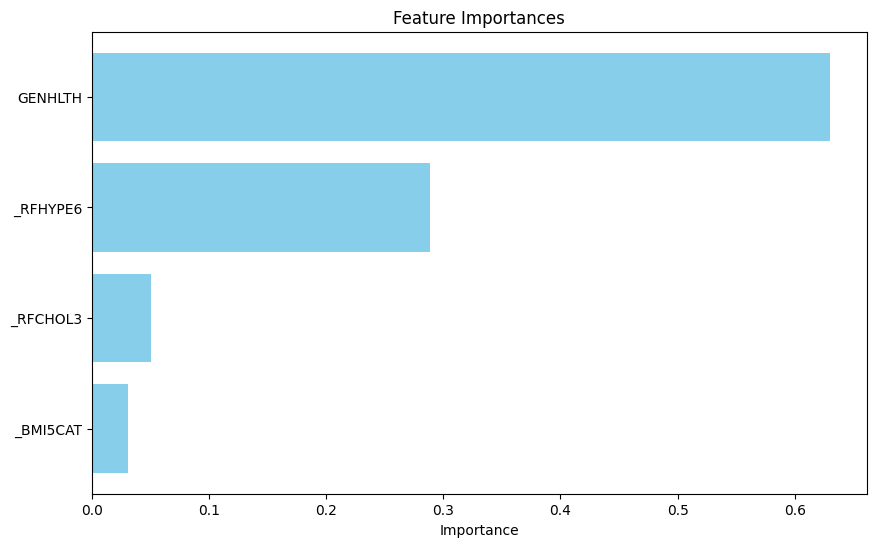

In [17]:
import matplotlib.pyplot as plt
import numpy as np

# Extract the feature importances and corresponding feature names
importances = cv_model.bestModel.featureImportances
feature_importance = [(name, importance) for name, importance in zip(feature_columns, importances)]

# Filter out features with zero importance (if any)
non_zero_importance = [(name, importance) for name, importance in feature_importance if importance > 0]

# Sort features by importance (descending order)
sorted_features = sorted(non_zero_importance, key=lambda x: x[1], reverse=True)

# Extract sorted feature names and their importances
sorted_feature_names = [name for name, importance in sorted_features]
sorted_importances = [importance for name, importance in sorted_features]

# Plotting
plt.figure(figsize=(10, 6))
plt.barh(sorted_feature_names, sorted_importances, color='skyblue')
plt.xlabel('Importance')
plt.title('Feature Importances')
plt.gca().invert_yaxis()  # Invert the y-axis to display the most important features at the top
plt.show()
